In [ ]:
# default_exp core

# Core functions

> API details.

In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.all import *
import pandas as pd

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Preprocces functions

## M4

In [ ]:
# export
def ts_lists(ts:np.ndarray)-> L:
    """Transforms a `np.ndarray` of shape (timeseries, max_time) to a list of timeseries with shape (1,time).
    
    where:
    
    max_time = the length of the longest timeserie
    
    time = the length of the non-nan values of that specific timeserie    
    """
    lst = L()
    for time_series in ts:
        lst.append(time_series[~np.isnan(time_series)][None,:])
    return lst

In [ ]:
# hide
ts = np.array([np.arange(0,10.),
               np.arange(0,10.)
              ])
ts[1,-1] = np.NaN

r = ts_lists(ts)
test_eq(r[0],np.arange(0,10.)[None,:])
test_eq(r[1],np.arange(0,9.)[None,:])
test_eq(r[0].shape,(1,10))

In [ ]:
ts

array([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
       [ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8., nan]])

In [ ]:
ts_lists(ts)

(#2) [array([[0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]]),array([[0., 1., 2., 3., 4., 5., 6., 7., 8.]])]

## Gas-usage


In [ ]:
# export 
class ToElapsed():
    changed = False    
    def __call__(self, s):
        if pd.api.types.is_datetime64_any_dtype(s.dtype):            
            self.changed = True
            return s.astype(np.int64) // 10 ** 9
        return s
    
    def decode(self, s):
        if self.changed:    
            return pd.Series(pd.to_datetime(s *(10 ** 9)))
        return s
    

In [ ]:
# hide
s = pd.Series([pd.Timestamp('1970')+pd.Timedelta(hours=1)*x for x in range(24)])

In [ ]:
s

0    1970-01-01 00:00:00
1    1970-01-01 01:00:00
2    1970-01-01 02:00:00
3    1970-01-01 03:00:00
4    1970-01-01 04:00:00
5    1970-01-01 05:00:00
6    1970-01-01 06:00:00
7    1970-01-01 07:00:00
8    1970-01-01 08:00:00
9    1970-01-01 09:00:00
10   1970-01-01 10:00:00
11   1970-01-01 11:00:00
12   1970-01-01 12:00:00
13   1970-01-01 13:00:00
14   1970-01-01 14:00:00
15   1970-01-01 15:00:00
16   1970-01-01 16:00:00
17   1970-01-01 17:00:00
18   1970-01-01 18:00:00
19   1970-01-01 19:00:00
20   1970-01-01 20:00:00
21   1970-01-01 21:00:00
22   1970-01-01 22:00:00
23   1970-01-01 23:00:00
dtype: datetime64[ns]

In [ ]:
tmf = ToElapsed()
tmf(s)

0         0
1      3600
2      7200
3     10800
4     14400
5     18000
6     21600
7     25200
8     28800
9     32400
10    36000
11    39600
12    43200
13    46800
14    50400
15    54000
16    57600
17    61200
18    64800
19    68400
20    72000
21    75600
22    79200
23    82800
dtype: int64

In [ ]:
tmf.decode(tmf(s))

0    1970-01-01 00:00:00
1    1970-01-01 01:00:00
2    1970-01-01 02:00:00
3    1970-01-01 03:00:00
4    1970-01-01 04:00:00
5    1970-01-01 05:00:00
6    1970-01-01 06:00:00
7    1970-01-01 07:00:00
8    1970-01-01 08:00:00
9    1970-01-01 09:00:00
10   1970-01-01 10:00:00
11   1970-01-01 11:00:00
12   1970-01-01 12:00:00
13   1970-01-01 13:00:00
14   1970-01-01 14:00:00
15   1970-01-01 15:00:00
16   1970-01-01 16:00:00
17   1970-01-01 17:00:00
18   1970-01-01 18:00:00
19   1970-01-01 19:00:00
20   1970-01-01 20:00:00
21   1970-01-01 21:00:00
22   1970-01-01 22:00:00
23   1970-01-01 23:00:00
dtype: datetime64[ns]

In [ ]:
# hide
test_eq(tmf(s),
       np.arange(0,3600*24,3600))

test_eq(tmf.decode(pd.Series(np.arange(0,3600*24,3600))).values,s.values)
test_eq_type(tmf.decode(pd.Series(np.arange(0,3600*24,3600))), s)

In [ ]:
# hide
tmf = ToElapsed()
test_eq(tmf(pd.Series(np.arange(0,3600*24,3600))),
       np.arange(0,3600*24,3600))

test_eq(tmf.decode(pd.Series(np.arange(0,3600*24,3600))),
       np.arange(0,3600*24,3600))

In [ ]:
# export
def make_interval(
    df: pd.DataFrame,
    to_split_col:str='datetime',
    interval=3600,
    max_splits=100000,
    callback_error=None,
) -> L(pd.DataFrame):
    """Will check if column `to_split_col` in `df` has interval size of `interval`, 
    if not will make it happen and return a list where this is done.
    
    This works both when type of `to_split_col` is numeric or `pd.Timestamp`
    
    """
    tmf = ToElapsed()
    df[to_split_col] = tmf(df[to_split_col])    
    df.index = df[to_split_col]
    df = df.sort_index()
    index = df.index.to_numpy()
    df["delta"] = abs(
        (df[to_split_col] - df[to_split_col].shift(1))
    )    
    mask = df["delta"] != interval
    starts = np.arange(len(mask))[mask]
    ends = list(starts[1:])+L(len(mask))
    
    del df["delta"]

    if len(ends) > max_splits:
        if callback_error:
            callback_error()
        raise Exception(
            f"number of splits {len(not_hour)} > {max_splits}: \n{not_hour}"
        )
#     print(starts,ends)
    dfs = L()
    for start, end in zip(starts, ends):
        _df = df.iloc[start: end,:]
        _df.loc[:,to_split_col] = tmf.decode(_df[to_split_col])
        dfs.append(_df)

    return dfs

In [ ]:
# hide
df_start = pd.DataFrame({'dt':np.arange(0,10),
                  'x':np.arange(0,10),
                  })
df_end = pd.DataFrame({'dt':np.arange(15,20),
                  'x':np.arange(0,5) ,
                  })
df = df_start.append(df_end)

In [ ]:
df.T

,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4
dt,0,1,2,3,4,5,6,7,8,9,15,16,17,18,19
x,0,1,2,3,4,5,6,7,8,9,0,1,2,3,4


In [ ]:
r = make_interval(df,'dt',1)
r[0]

,dt,x
dt,,
0,0,0
1,1,1
2,2,2
3,3,3
4,4,4
5,5,5
6,6,6
7,7,7
8,8,8


In [ ]:
r[1]

,dt,x
dt,,
15,15,0
16,16,1
17,17,2
18,18,3
19,19,4


In [ ]:
# hide
r = make_interval(df,'dt',1)
test_eq(len(r),2)

test_eq(r[0],df_start)
test_eq(r[1],df_end)

test_eq(r[0].shape,df_start.shape)
test_eq(r[1].shape,df_end.shape)

In [ ]:
# hide
df_start = pd.DataFrame({'datetime':[pd.Timestamp('1970-01-01')+pd.Timedelta(hours=1)*x for x in range(48)],
                  'x':np.arange(0,48),
                  })
df_end = pd.DataFrame({'datetime':[pd.Timestamp('1970-01-04')+pd.Timedelta(hours=1)*x for x in range(24)],
                  'x':np.arange(0,24),
                  })
df = df_start.append(df_end)

r = make_interval(df,'datetime', 3600)
test_eq(len(r),2)

test_eq(r[0].values, df_start.values)
test_eq(r[1].values, df_end.values)

test_eq(r[0].shape,df_start.shape)
test_eq(r[1].shape,df_end.shape)


In [ ]:
# export
def melted_ts_2_lists(ts:pd.DataFrame, melted_col_name:str, **kwargs)->L:
    dfs = L()
    for c in set(ts[melted_col_name]):
        _df = ts[ts[melted_col_name] == c]
        r = make_interval(_df,**kwargs)
        dfs += r
    return dfs

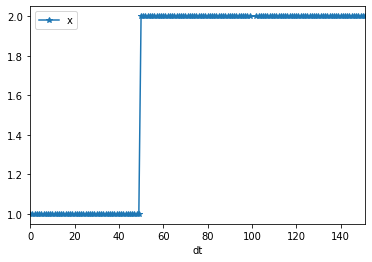

In [ ]:
df_start = pd.DataFrame({'dt':np.arange(0,100),
                  'x':L([1]*50) + L([2]*50),
                  })
df_end = pd.DataFrame({'dt':np.arange(102,152),
                  'x':L([2]*50) ,
                  })
df = df_start.append(df_end)
df.plot(x='dt',y='x',marker='*')

In [ ]:
r = melted_ts_2_lists(df,'x',to_split_col='dt',interval=1)
test_eq(type(r), type(L(0)))
test_eq(len(r), 3)

test_eq_type(r[2], df_end)

test_eq(r[0].shape, (50,2))
test_eq(r[1].shape, (50,2))
test_eq(r[2].shape, (50,2))

[0] (#1) [50]
[ 0 50] (#2) [50,100]


/home/tako/dev/env37/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# hide
from nbdev.test import *
test_nb()

from nbdev.export import *
notebook2script()



TypeError: test_nb() missing 1 required positional argument: 'fn'

In [ ]:
from nbdev import export

In [ ]:
dir(export)

['Config',
 'ConfigParser',
 'DocsTestClass',
 'IN_COLAB',
 'IN_IPYTHON',
 'IN_NOTEBOOK',
 'NotebookNotary',
 'Optional',
 'Param',
 'Path',
 'Process',
 'ProcessPoolExecutor',
 'Queue',
 'ReLibName',
 'TextWrapper',
 'Union',
 '_EmptyModule',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_add2add',
 '_deal_import',
 '_not_private',
 '_notebook2script',
 '_re__all__def',
 '_re_all_def',
 '_re_baseurl',
 '_re_blank_export',
 '_re_class_func_def',
 '_re_default_exp',
 '_re_import',
 '_re_import1',
 '_re_index_custom',
 '_re_index_idx',
 '_re_index_mod',
 '_re_mod_export',
 '_re_obj_def',
 '_re_patch_func',
 '_re_typedispatch_func',
 '_re_version',
 'add_init',
 'add_new_defaults',
 'anno_parser',
 'args_from_prog',
 'bool_arg',
 'call_parse',
 'check_re',
 'collections',
 'compose',
 'concurrent',
 'core',
 'create_config',
 'create_mod_file',
 'enum',
 'export_names',
 'extra_add',
 'find_default_export',
